### SAD Score Distribution

Author: Sophie Sigfstead

Purpose of the notebook: Currently I am working to design a better thresholding mechanism for our SNP activity difference scores. One method proposed is to use FDR to include / disclude SNPs based on whether or not we reject the null hypothesis of mean(SAD_values) for <snp_j> = 0. 

As such, I'm doing some simple visualizations here to see how the sad values are distributed. 

In [1]:
import pandas as pd
import os
from tqdm import tqdm

# Define the directory containing the CSV files
csv_directory = "../GWAS_Data/1000genomes_as_csv"

# Create an empty DataFrame to hold the combined SAD values
combined_df = pd.DataFrame()

# Define the maximum number of rows
max_rows = 5_000_000

# Loop through all CSV files in the directory
for file_name in (os.listdir(csv_directory)):
    if file_name.endswith(".csv"):  # Ensure the file is a CSV
        file_path = os.path.join(csv_directory, file_name)
        
        # Read the CSV file in chunks to handle large file sizes
        chunk_size = 10**6  # Adjust chunk size as needed
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Extract all columns starting with "SAD"
            sad_columns = [col for col in chunk.columns if col.startswith("SAD")]
            sad_chunk = chunk[sad_columns]
            
            # Append the SAD columns to the combined DataFrame
            combined_df = pd.concat([combined_df, sad_chunk], ignore_index=True)
            # Break the outer loop if the maximum row limit is reached
            if len(combined_df) >= max_rows:
                break
            
    # Break the outer loop if the maximum row limit is reached
    if len(combined_df) >= max_rows:
        break    # Break the outer loop if the maximum row limit is reached
       

# Save the combined DataFrame to a CSV file
combined_df.to_csv("combined_sad_values.csv", index=False)

# Display the first few rows of the combined DataFrame
print(combined_df.head())



       SAD0      SAD1      SAD2      SAD3      SAD4      SAD5      SAD6  \
0  0.000029  0.000004 -0.000087 -0.000120 -0.000009  0.000006  0.000010   
1  0.000142 -0.000034 -0.000021  0.000067  0.000462  0.000327  0.000635   
2 -0.000003  0.000141  0.000202  0.000088  0.000104  0.000171  0.000078   
3  0.000049  0.000041  0.000054  0.000051  0.000037  0.000045  0.000041   
4  0.000023  0.000017  0.000014  0.000039  0.000024  0.000031  0.000016   

       SAD7      SAD8      SAD9  ...    SAD674    SAD675    SAD676    SAD677  \
0 -0.000017 -0.000023 -0.000057  ... -0.002296  0.002531 -0.000041  0.002285   
1  0.000135  0.000390 -0.000043  ...  0.002403  0.002401  0.000389  0.001868   
2  0.000091  0.000102  0.000137  ...  0.000347 -0.000556  0.001503 -0.000402   
3  0.000027  0.000044  0.000039  ...  0.000195  0.000122  0.000713 -0.000057   
4  0.000019  0.000024  0.000011  ...  0.000821  0.001335  0.000609  0.001102   

     SAD678    SAD679    SAD680    SAD681    SAD682    SAD683  
0  0

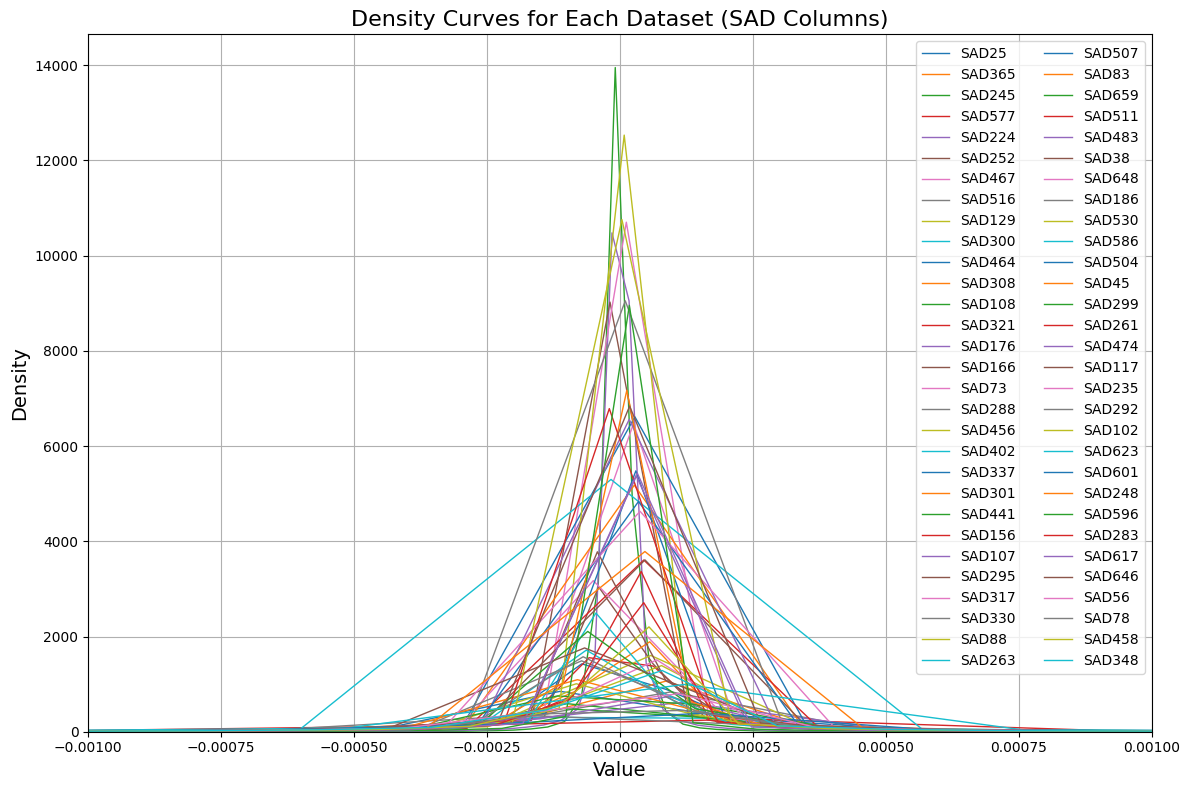

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 

# Assuming `df` contains the data with columns SAD0, SAD1, ..., SAD683
columns_to_plot = [col for col in combined_df.columns if col.startswith("SAD")]
columns_to_plot = random.sample(columns_to_plot, 60)
combined_df = combined_df[0:1000000]

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot each column as a KDE (Kernel Density Estimate) plot
for column in columns_to_plot:
    sns.kdeplot(combined_df[column], label=column, linewidth=1)

# Add labels and legend
plt.title("Density Curves for Each Dataset (SAD Columns)", fontsize=16)
plt.xlabel("Value", fontsize=14)
plt.xlim(-0.001, 0.001)
plt.ylabel("Density", fontsize=14)
plt.legend(loc='upper right', fontsize=10, ncol=2)  # Adjust legend placement and size
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# Compute row-wise mean
combined_df['Row_Mean'] = combined_df.mean(axis=1)

# Generate summary statistics for the row-wise mean
summary_stats = combined_df['Row_Mean'].describe()


print("\nSummary Statistics for Row-Wise Means:")
print(summary_stats)


Summary Statistics for Row-Wise Means:
count    1.000000e+06
mean    -6.467655e-07
std      1.626940e-04
min     -1.192600e-02
25%     -1.365890e-05
50%      3.143567e-07
75%      1.424111e-05
max      1.304881e-02
Name: Row_Mean, dtype: float64


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Number of samples to generate
total_samples = 10000
sample_size = 33

# storage for results
results = []


for _ in range(total_samples):
    # randomly select a row
    random_row = combined_df.sample(n=1, axis=0).iloc[0]
    
    # sample 33 SAD values from the row
    sample = random_row.sample(n=sample_size, replace=False)
    
    # perform a one sample t-test; Null hypothesis u = 0
    t_stat, p_value = ttest_1samp(sample, popmean=0)
    
    # store results
    results.append({
        "sample_mean": sample.mean(),
        "t_stat": t_stat,
        "p_value": p_value
    })


results_df = pd.DataFrame(results)

results_df.head()

,sample_mean,t_stat,p_value
0,7.757273e-06,2.565754,0.015183
1,-8.428788e-06,-1.346001,0.187761
2,7.972727e-07,0.186641,0.853121
3,-7.979697e-06,-2.597809,0.014064
4,1.135758e-06,0.394251,0.696011


In [5]:
# Summary of hypothesis testing
print("Summary of hypothesis testing:")
print(results_df.describe()) 

Summary of hypothesis testing:
        sample_mean        t_stat       p_value
count  1.000000e+04  10000.000000  1.000000e+04
mean  -5.347697e-06      0.026389  2.259418e-01
std    1.928360e-04      2.943890  2.817501e-01
min   -5.499880e-03    -13.718163  1.061603e-16
25%   -1.489962e-05     -1.765119  4.295401e-03
50%    9.075758e-08      0.016978  8.293900e-02
75%    1.513965e-05      1.814495  3.788245e-01
max    1.922558e-03     15.840763  9.996769e-01


In [6]:
len(results_df[results_df['p_value'] < 0.005])/10000

0.2576

Previously, ~25-30% of SNPs were included in the GWAS (filtered) so it may be alpha = 0.005 is a good option, but different alpha values can be tested. 